In [1]:
%matplotlib inline
from mnist import MNIST
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from math import exp, log
import scipy.io
import random
import csv

In [2]:
THETA_LEN = 100
V_LEN = 100
TOTAL_LEN = THETA_LEN + V_LEN

In [3]:
def create_X():
    W1 = np.random.randn(THETA_LEN, 1)
    W2 = np.random.randn(THETA_LEN, 1)
    Theta_no_shape = np.random.uniform(0.0, 2.0*np.pi, THETA_LEN)
    Theta = Theta_no_shape.reshape(THETA_LEN, 1)
    
    X1 = np.add(np.multiply(8, np.cos(Theta)), W1)
    X2 = np.add(np.multiply(8, np.sin(Theta)), W2)
    X_a = np.hstack((X1, X2))
    
    V1 = np.random.randn(V_LEN, 1)
    V2 = np.random.randn(V_LEN, 1)
    V = np.hstack((V1, V2))
    X = np.concatenate((X_a, V), axis=0)
    return X1, X2, V1, V2, X

In [4]:
def create_Y():
    Y1 = np.ones((THETA_LEN, 1))
    Y2 = np.multiply(-1, np.ones((V_LEN, 1)))
    Y = np.concatenate((Y1, Y2), axis=0)
    return Y

In [5]:
def get_K_from_func(X, func):
    K = np.zeros((TOTAL_LEN, TOTAL_LEN))
    for i in range(len(X)):
        for j in range(len(X)):
            K[i][j] = func(X[j], X[i])
    return K

def gaussian_k_func(x, z, gamma):
    x_min_z = np.subtract(x, z)
    return np.exp(np.multiply(-1.0 * gamma, np.dot(x_min_z.T, x_min_z)))
    
def create_gaussian_kernel(X, gamma):
    def gaussian_k_func(x, z):
        x_min_z = np.subtract(x, z)
        return np.exp(np.multiply(-1.0 * gamma, np.dot(x_min_z.T, x_min_z)))
    return get_K_from_func(X, gaussian_k_func)
    
def poly_k_func(x, z):
    return (1.0 + np.dot(x.T, z)) ** 2
def create_polynomial_kernel(X):
    return get_K_from_func(X, poly_k_func)

In [6]:
def get_alpha_closed_form_sol(K, Y, reg=1e-6):
    lami = np.zeros((TOTAL_LEN, TOTAL_LEN))
    np.fill_diagonal(lami, reg)
    return np.dot(np.linalg.inv(np.add(K, lami)), Y)

In [7]:
def get_predictions(K, alpha):
    rounder = np.vectorize(lambda x: -1.0 if x <= 0 else 1.0)
    return rounder(np.dot(K, alpha))

In [8]:
def get_accuracy(predictions, real_labels):
    correct, total = 0, 0
    for i in range(predictions.shape[0]):
        if predictions[i] == real_labels[i]:
            correct += 1
        total += 1
    return correct/total

In [9]:
POLY_REG = 1e-6
GAUSSIAN_REG = 1e-4
GAMMAS = [10, 0.1, 0.001]

In [10]:
X1, X2, V1, V2, X = create_X()
Y = create_Y()

In [11]:
poly_K = create_polynomial_kernel(X)
poly_alpha = get_alpha_closed_form_sol(poly_K, Y, POLY_REG)
poly_predictions = get_predictions(poly_K, poly_alpha)
poly_accuracy = get_accuracy(poly_predictions, Y)

gaussian_K = create_gaussian_kernel(X, GAMMAS[2])
gaussian_alpha = get_alpha_closed_form_sol(gaussian_K, Y, GAUSSIAN_REG)
gaussian_predictions = get_predictions(gaussian_K, gaussian_alpha)
gaussian_accuracy = get_accuracy(gaussian_predictions, Y)

print(poly_accuracy)
print(gaussian_accuracy)

0.995
1.0


In [12]:
print(X.shape, Y.shape)

(200, 2) (200, 1)


(200, 1)
(43677, 200)


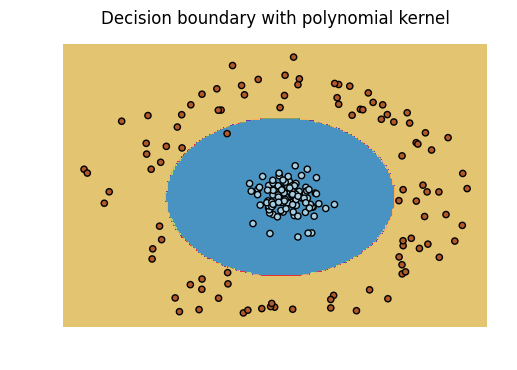

In [13]:
h = 0.1
# X - some data in 2dimensional np.array

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

def get_poly_predictions_for_new_data(X, poly_alpha, new_data):
    n, _ = new_data.shape
    kernels = np.zeros(n)
    new_K = np.zeros((n, TOTAL_LEN))
    for i in range(len(X)):
        for j in range(n):
            new_K[j][i] = poly_k_func(X[i], new_data[j])
    print(new_K.shape)
    predictions = get_predictions(new_K, poly_alpha)
    return predictions

# here "model" is your model's prediction (classification) function
poly_K = create_polynomial_kernel(X)
poly_alpha = get_alpha_closed_form_sol(poly_K, Y, POLY_REG)
print(poly_alpha.shape)
Z = get_poly_predictions_for_new_data(X, poly_alpha, np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('off')
plt.title('Decision boundary with polynomial kernel')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

In [20]:
0 in Z

False

def get_gaussian_predictions_for_new_data(X, gaussian_alpha, new_data, gamma):
    n, _ = new_data.shape
    kernels = np.zeros(n)
    new_K = np.zeros((n, TOTAL_LEN))
    for i in range(len(X)):
        for j in range(n):
            new_K[j][i] = gaussian_k_func(X[i], new_data[j], gamma)
    predictions = get_predictions(new_K, gaussian_alpha)
    return predictions

# here "model" is your model's prediction (classification) function
gamma = GAMMAS[0]
gaussian_K = create_gaussian_kernel(X, gamma)
gaussian_alpha = get_alpha_closed_form_sol(gaussian_K, Y, GAUSSIAN_REG)
Z = get_gaussian_predictions_for_new_data(X, gaussian_alpha, np.c_[xx.ravel(), yy.ravel()], gamma)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('off')
plt.title('Decision boundary with gaussian kernel, gamma=10')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

/Users/nishadsingh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


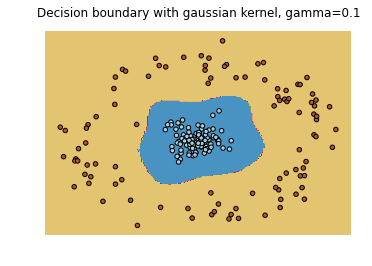

In [553]:
gamma = GAMMAS[1]
gaussian_K = create_gaussian_kernel(X, gamma)
gaussian_alpha = get_alpha_closed_form_sol(gaussian_K, Y, GAUSSIAN_REG)
Z = get_gaussian_predictions_for_new_data(X, gaussian_alpha, np.c_[xx.ravel(), yy.ravel()], gamma)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('off')
plt.title('Decision boundary with gaussian kernel, gamma=0.1')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

/Users/nishadsingh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


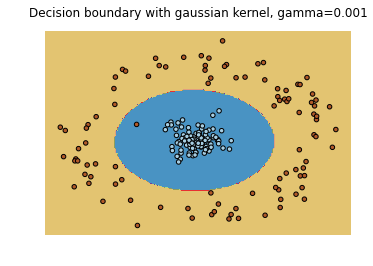

In [554]:
gamma = GAMMAS[2]
gaussian_K = create_gaussian_kernel(X, gamma)
gaussian_alpha = get_alpha_closed_form_sol(gaussian_K, Y, GAUSSIAN_REG)
Z = get_gaussian_predictions_for_new_data(X, gaussian_alpha, np.c_[xx.ravel(), yy.ravel()], gamma)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('off')
plt.title('Decision boundary with gaussian kernel, gamma=0.001')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)